In [1]:
# Cell 1
import scanpy as sc
import pandas as pd
import numpy as np
import torch, dgl          # optional, only if you want to build a graph right here
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from pathlib import Path

# paths – adjust if yours differ
DATA_DIR = Path("Data")
H5_EXPR   = DATA_DIR / "expression_matrix.h5"
POS_FILE  = DATA_DIR / "positions.txt"
TIF_IMG   = DATA_DIR / "histology.tif"          # optional, only for QC visuals

OUT_DIR   = DATA_DIR / "spaformer_prepared"
OUT_DIR.mkdir(exist_ok=True)

print("All paths OK ✓")

/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:104: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:128: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dZ):
/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:177: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/dgl/backend/pytorch/sparse.py:207: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated.

All paths OK ✓


In [2]:
# Cell 2
# 10x-style .h5 files can be read with scanpy.read_10x_h5
try:
    adata = sc.read_10x_h5(H5_EXPR)
except Exception as e:
    # If the file is an AnnData .h5ad produced elsewhere, fall back:
    adata = sc.read_h5ad(H5_EXPR)

print(adata)
print("genes  :", adata.n_vars)
print("cells  :", adata.n_obs)

AnnData object with n_obs × n_vars = 4992 × 33538
    var: 'gene_ids', 'feature_types', 'genome'
genes  : 33538
cells  : 4992


/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# Cell 3
cols = ["barcode", "fov", "unused1", "unused2", "x", "y"]
pos   = pd.read_csv(POS_FILE, header=None, names=cols)

# keep only relevant columns and ensure order matches adata.obs_names
pos = pos.set_index("barcode").loc[adata.obs_names]
coords = pos[["x", "y"]].to_numpy(float)

# min-max normalise to [0,1] – SpaFormer uses that range
coords_min = coords.min(0, keepdims=True)
coords_ptp = coords.max(0, keepdims=True) - coords_min
coords_norm = (coords - coords_min) / coords_ptp

# store in AnnData for convenience
adata.obsm["spatial"] = coords_norm
print("Spatial coords shape:", coords_norm.shape)

Spatial coords shape: (4992, 2)


In [4]:
# Cell 4
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]].copy()

print("After HVG filter  →  genes:", adata.n_vars, "  cells:", adata.n_obs)

/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


After HVG filter  →  genes: 3004   cells: 4992


/home/muscede2/anaconda3/envs/spaformer/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# Cell 5
k = 6                      # number of neighbours
nbrs = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(coords_norm)
_, idx = nbrs.kneighbors(coords_norm)

# build edge index
src = np.repeat(np.arange(adata.n_obs), k)
dst = idx[:, 1:].reshape(-1)
edges = np.stack([src, dst], axis=0).astype(np.int32)

print("Edge index shape:", edges.shape)   # (2, E)

# Quick DGL graph (optional)
g = dgl.graph((edges[0], edges[1]), num_nodes=adata.n_obs)
g.ndata["feat"] = torch.from_numpy(adata.X.toarray()).float()   # (cells × genes)
g.ndata["pos"]  = torch.from_numpy(coords_norm).float()
print(g)

Edge index shape: (2, 29952)
Graph(num_nodes=4992, num_edges=29952,
      ndata_schemes={'feat': Scheme(shape=(3004,), dtype=torch.float32), 'pos': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


In [6]:
# Cell 6
np.save(OUT_DIR / "X.npy",      adata.X.toarray().astype(np.float32))
np.save(OUT_DIR / "C.npy",      coords_norm.astype(np.float32))
np.save(OUT_DIR / "edges.npy",  edges)

print("Saved:", list(OUT_DIR.iterdir()))

Saved: [PosixPath('Data/spaformer_prepared/X.npy'), PosixPath('Data/spaformer_prepared/C.npy'), PosixPath('Data/spaformer_prepared/edges.npy')]


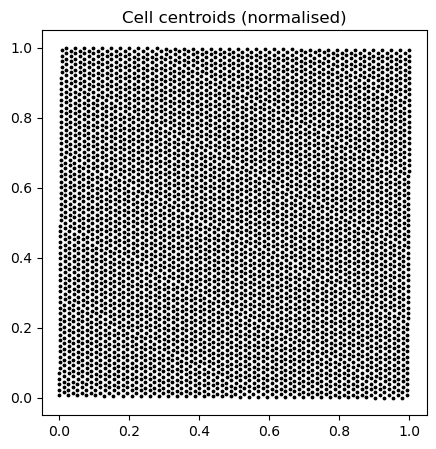

In [7]:
# Cell 7
plt.figure(figsize=(5,5))
plt.scatter(coords_norm[:,0], coords_norm[:,1], s=3, c="k")
plt.title("Cell centroids (normalised)")
plt.gca().set_aspect("equal")
plt.show()

In [9]:
import numpy as np, pandas as pd
import os

base = "Data/spaformer_prepared"

# load the pre-processed arrays
X     = np.load(os.path.join(base, "X.npy"))       # expression matrix
C     = np.load(os.path.join(base, "C.npy"))       # normalized (x,y)
edges = np.load(os.path.join(base, "edges.npy"))   # adjacency

# sanity‐check
print("X:",     X.shape,     X.dtype)
print("C:",     C.shape,     C.min(), C.max())
print("edges:", edges.shape, edges.dtype)

# quick peek at the first 5 coordinates
pd.DataFrame(C[:5], columns=["x_norm","y_norm"])

X: (4992, 3004) float32
C: (4992, 2) 0.0 1.0
edges: (2, 29952) int32


,x_norm,y_norm
0,0.000861,0.132577
1,0.650409,0.799773
2,0.040913,0.343246
3,0.762059,0.150170
4,0.185616,0.740749
